In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from utils import (Expando, _calculate_S_star_BL_G,_calculate_S_star_BL_L, calculate_cvar_left, _left_tail_weighted_sum, _left_tail_mask )
import gurobipy as gp
from gurobipy import GRB

In [15]:
class ContractData:
    def __init__(self, scenario_path, time_horizon, num_scenarios, discount_rate_G=0.02, discount_rate_L=0.05, alpha=0.95,
                 strikeprice_min=0, strikeprice_max=1000, contract_amount_min=0, contract_amount_max=1000,
                 A_G=0.5, A_L=0.5, tau_G=0.5, tau_L=0.5, Scenarios_S=False, Scenarios_M=False,
                 Discount=True, K_G_lambda_Sigma=0, K_L_lambda_Sigma=0):
        """Initialize data for contract negotiation.

        Args:
            scenario_path (str): Path to scenario data files
            time_horizon (int): Time horizon in years
            num_scenarios (int): Number of scenarios
            discount_rate_G (float): Generator's discount rate (default: 0.02)
            discount_rate_L (float): Load's discount rate (default: 0.05)
            alpha (float): CVaR confidence level (default: 0.95)
            strikeprice_min (float): Minimum strike price (default: 0)
            strikeprice_max (float): Maximum strike price (default: 1000)
            contract_amount_min (float): Minimum contract amount (default: 0)
            contract_amount_max (float): Maximum contract amount (default: 1000)
            A_G (float): Generator's risk aversion parameter (default: 0.5)
            A_L (float): Load's risk aversion parameter (default: 0.5)
            tau_G (float): Generator's bargaining power (default: 0.5)
            tau_L (float): Load's bargaining power (default: 0.5)
            Scenarios_S (bool): Strike Price indexed by scenarios (default: False)
            Scenarios_M (bool): Contract Amount M indexed by scenarios (default: False)
            Discount (bool): Use discounting for strike price borders (default: True)
            K_G_lambda_Sigma (float): Generator's lambda adjustment constant (default: 0)
            K_L_lambda_Sigma (float): Load's lambda adjustment constant (default: 0)
        """
        # Store parameters
        self.time_horizon = time_horizon
        self.num_scenarios = num_scenarios
        self.alpha = alpha
        self.A_G = A_G
        self.A_L = A_L
        self.tau_G = tau_G
        self.tau_L = tau_L
        self.Scenarios_S = Scenarios_S
        self.Scenarios_M = Scenarios_M
        self.Discount = Discount
        self.K_G_lambda_Sigma = K_G_lambda_Sigma
        self.K_L_lambda_Sigma = K_L_lambda_Sigma

        # Contract limits
        self.strikeprice_min = strikeprice_min
        self.strikeprice_max = strikeprice_max
        self.contract_amount_min = contract_amount_min
        self.contract_amount_max = contract_amount_max

        # Calculate discount factors
        self.discount_factors_G_arr = (1 / (1 + discount_rate_G) ** np.arange(time_horizon))[:, None]
        self.discount_factors_L_arr = (1 / (1 + discount_rate_L) ** np.arange(time_horizon))[:, None]

        # Load scenario data
        self._load_scenarios(scenario_path)

        # Calculate derived values
        self._calculate_derived_values()

        # Calculate strike price borders
        self._calculate_strike_price_borders()
        
    def _load_scenarios(self, scenario_path):
        """Load all scenario data from files."""
        scenario_pattern = f"{{type}}_scenarios_reduced_{20}y_{self.num_scenarios}s.csv"
        
        # Load price scenarios
        self.price_G = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='price')}", index_col=0).values[:self.time_horizon, :]
        self.price_L = self.price_G.copy()  # Assuming same prices for both parties
        
        # Load production scenarios
        self.production_G = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='production')}", 
                                      index_col=0).values[:self.time_horizon, :]
        
        # Load capture rate scenarios
        self.capture_rate = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='capture_rate')}", 
                                      index_col=0).values[:self.time_horizon, :]
        
        # Load load scenarios
        self.load_scenarios = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='load')}", 
                                        index_col=0).values[:self.time_horizon, :]
        
        # Load load capture rate scenarios
        self.load_CR = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='load_capture_rate')}", 
                                 index_col=0).values[:self.time_horizon, :]
        
        # Load probabilities
        self.PROB = pd.read_csv(f"{scenario_path}/{scenario_pattern.format(type='probabilities')}", 
                              index_col=0).values.flatten()
        
    def _calculate_derived_values(self):
        """Calculate derived values needed for optimization."""
        # Time indices
        self.TIME = range(self.time_horizon)
        self.SCENARIOS = range(self.num_scenarios)
        
        # Calculate no-contract earnings
        self.net_earnings_no_contract_priceG_G = (self.discount_factors_G_arr * self.capture_rate * self.price_G * self.production_G).sum(axis=0)
        self.net_earnings_no_contract_priceL_L = (-self.discount_factors_L_arr * self.load_scenarios * self.load_CR * self.price_L).sum(axis=0)
        
        # Calculate CVaR for no-contract case
        self.CVaR_no_contract_G = calculate_cvar_left(self.net_earnings_no_contract_priceG_G, self.PROB, self.alpha)
        self.CVaR_no_contract_L = calculate_cvar_left(self.net_earnings_no_contract_priceL_L, self.PROB, self.alpha)
        
        # Calculate threat points (Zeta values)
        self.Zeta_G = ((1 - self.A_G) * (self.PROB * self.net_earnings_no_contract_priceG_G).sum() + self.A_G * self.CVaR_no_contract_G)
        self.Zeta_L = ((1 - self.A_L) * (self.PROB * self.net_earnings_no_contract_priceL_L).sum() + self.A_L * self.CVaR_no_contract_L)
        
        # Calculate expected price
        self.expected_price = (self.PROB * self.price_G.mean(axis=0)).sum()
        
        # Calculate capture price for generator
        self.Capture_price_G_avg = ((self.capture_rate * self.price_G).sum(axis=0) / self.capture_rate.sum(axis=0))

        # Calculate expected lambda sum (needed for strike price borders)
        self.expected_lambda_sum_true = self.price_G.sum(axis=0)  # Sum over time for each scenario

    def _calculate_strike_price_borders(self):
        """Calculate strike price borders (SR* and SU*) based on CVaR calculations."""
        if self.Discount:
            # Use discounted prices
            discounted_prices_G = (self.price_G * self.discount_factors_G_arr)
            discounted_prices_L = (self.price_L * self.discount_factors_L_arr)
            
            # Sum over time for each scenario
            lambda_sum_G_discounted = discounted_prices_G.sum(axis=0)
            lambda_sum_L_discounted = discounted_prices_L.sum(axis=0)
            
            # Expected values with discounting
            expected_lambda_sum_discounted_G = (self.PROB * lambda_sum_G_discounted).sum()
            expected_lambda_sum_discounted_L = (self.PROB * lambda_sum_L_discounted).sum()
            
            # Get masks using discounted earnings - Generator
            ord_G, bidx_G = _left_tail_mask(
                self.net_earnings_no_contract_priceG_G,
                self.PROB,
                self.alpha
            )

            neg_ord_G, neg_bidx_G = _left_tail_mask(
                -self.net_earnings_no_contract_priceG_G,
                self.PROB,
                self.alpha
            )

            # Get masks using discounted earnings - Load
            ord_L, bidx_L = _left_tail_mask(
                self.net_earnings_no_contract_priceL_L,
                self.PROB,
                self.alpha
            )

            neg_ord_L, neg_bidx_L = _left_tail_mask(
                -self.net_earnings_no_contract_priceL_L,
                self.PROB,
                self.alpha
            )
            
            # Calculate CVaR terms with discounted values - Generator
            tail_G = _left_tail_weighted_sum(
                self.PROB,
                lambda_sum_G_discounted,
                ord_G, bidx_G,
                self.alpha
            )
            
            neg_tail_G = _left_tail_weighted_sum(
                self.PROB,
                lambda_sum_G_discounted,
                neg_ord_G, neg_bidx_G,
                self.alpha
            )

            # Calculate CVaR terms with discounted values - Load
            tail_L = _left_tail_weighted_sum(
                self.PROB,
                lambda_sum_L_discounted,
                ord_L, bidx_L,
                self.alpha
            )

            neg_tail_L = _left_tail_weighted_sum(
                self.PROB,
                lambda_sum_L_discounted,
                neg_ord_L, neg_bidx_L,
                self.alpha
            )
            
            # Calculate terms with discounted values
            self.term1_G_new = (
                ((1-self.A_G) * expected_lambda_sum_discounted_G + 
                self.K_G_lambda_Sigma) + 
                self.A_G * neg_tail_G
            ) / (self.discount_factors_G_arr.sum())

            self.term2_G_new = (
                ((1-self.A_G) * expected_lambda_sum_discounted_G + 
                self.K_G_lambda_Sigma) + 
                self.A_G * tail_G
            ) / (self.discount_factors_G_arr.sum())

            # Calculate terms with discounted values
            self.term3_L_new = (
                ((1-self.A_L) * expected_lambda_sum_discounted_L + 
                self.K_L_lambda_Sigma) + 
                self.A_L * neg_tail_L
            ) / (self.discount_factors_L_arr.sum())

            self.term4_L_new = (
                ((1-self.A_L) * expected_lambda_sum_discounted_L + 
                self.K_L_lambda_Sigma) + 
                self.A_L * tail_L
            ) / (self.discount_factors_L_arr.sum())
        else:
            # Use non-discounted prices
            # Get masks using non-discounted earnings - Generator
            ord_G, bidx_G = _left_tail_mask(
                self.net_earnings_no_contract_priceG_G,
                self.PROB,
                self.alpha
            )

            neg_ord_G, neg_bidx_G = _left_tail_mask(
                -self.net_earnings_no_contract_priceG_G,
                self.PROB,
                self.alpha
            )

            # Get masks using non-discounted earnings - Load
            ord_L, bidx_L = _left_tail_mask(
                self.net_earnings_no_contract_priceL_L,
                self.PROB,
                self.alpha
            )

            neg_ord_L, neg_bidx_L = _left_tail_mask(
                -self.net_earnings_no_contract_priceL_L,
                self.PROB,
                self.alpha
            )
            
            # Calculate expected lambda sum (probability-weighted)
            expected_lambda_sum_per_scenario = self.expected_lambda_sum_true
            expected_lambda_sum = (self.PROB * expected_lambda_sum_per_scenario).sum()
            
            # Calculate CVaR terms with non-discounted values - Generator
            tail_G = _left_tail_weighted_sum(
                self.PROB,
                expected_lambda_sum_per_scenario,
                ord_G, bidx_G,
                self.alpha
            )
            
            neg_tail_G = _left_tail_weighted_sum(
                self.PROB,
                expected_lambda_sum_per_scenario,
                neg_ord_G, neg_bidx_G,
                self.alpha
            )

            # Calculate CVaR terms with non-discounted values - Load
            tail_L = _left_tail_weighted_sum(
                self.PROB,
                expected_lambda_sum_per_scenario,
                ord_L, bidx_L,
                self.alpha
            )

            neg_tail_L = _left_tail_weighted_sum(
                self.PROB,
                expected_lambda_sum_per_scenario,
                neg_ord_L, neg_bidx_L,
                self.alpha
            )

            # Calculate terms (use time_horizon as time_periods)
            time_periods = self.time_horizon
            
            self.term1_G_new = (
                ((1-self.A_G) * expected_lambda_sum + 
                self.K_G_lambda_Sigma) + 
                self.A_G * neg_tail_G
            ) / time_periods
            
            self.term2_G_new = (
                ((1-self.A_G) * expected_lambda_sum + 
                self.K_G_lambda_Sigma) + 
                self.A_G * tail_G
            ) / time_periods
            
            self.term3_L_new = (
                expected_lambda_sum + 
                self.A_L * neg_tail_L + 
                self.K_L_lambda_Sigma - 
                self.A_L * expected_lambda_sum
            ) / time_periods
            
            self.term4_L_new = (
                expected_lambda_sum + 
                self.A_L * tail_L
            ) / time_periods
        
        # Calculate SR* and SU* (convert from Mio EUR/GWh to EUR/MWh)
        self.SR_star_new = np.min([self.term1_G_new, self.term2_G_new, self.term3_L_new]) * 1e3
        self.SU_star_new = np.max([self.term1_G_new, self.term2_G_new, self.term4_L_new]) * 1e3
        
        print(f"Calculated SR* (Hourly Price [EUR/MWh]): {self.SR_star_new:.4f}")
        print(f"Calculated SU* (Hourly Price [EUR/MWh]): {self.SU_star_new:.4f}")

In [16]:
class NashBargaining:
    def __init__(self, input_data):
        """Initialize contract negotiation model with loaded scenarios.
        
        Args:
            input_data: Input data object containing loaded scenarios and parameters
        """        
        self.data = input_data
        self.results = Expando()
        self.variables = Expando()
        self.constraints = Expando()
        
        self._build_model()

    def _get_S(self, s=None):
        """Helper method to access strike price variable S.
        
        Args:
            s: Scenario index (optional, required if S is scenario-indexed)
            
        Returns:
            Gurobi variable (S[s] if indexed, S if scalar)
        """
        if self.data.Scenarios_S:
            if s is None:
                raise ValueError("Scenario index required when S is scenario-indexed")
            return self.variables.S[s]
        else:
            return self.variables.S

    def _get_M(self, s=None):
        """Helper method to access contract amount variable M.
        
        Args:
            s: Scenario index (optional, required if M is scenario-indexed)
            
        Returns:
            Gurobi variable (M[s] if indexed, M if scalar)
        """
        if self.data.Scenarios_M:
            if s is None:
                raise ValueError("Scenario index required when M is scenario-indexed")
            return self.variables.M[s]
        else:
            return self.variables.M

    def _build_variables(self):
        """Build optimization variables for contract negotiation."""
        EPS = 1e-8  # Small positive number for numerical stability
        
        # Define log-based auxiliary variables
        for name in ['arg_G', 'arg_L', 'log_arg_G', 'log_arg_L']:
              setattr(self.variables, name, self.model.addVar(lb=EPS, name=name))

        # Define core optimization variables (per scenario or scalar)
        if self.data.Scenarios_S:
            setattr(self.variables, 'S', self.model.addVars(self.data.SCENARIOS, lb=self.data.strikeprice_min, ub=self.data.strikeprice_max, name='Strike_Price'))
        else: 
            setattr(self.variables, 'S', self.model.addVar(lb=self.data.strikeprice_min, ub=self.data.strikeprice_max, name='Strike_Price'))

        if self.data.Scenarios_M:
            setattr(self.variables, 'M', self.model.addVars(self.data.SCENARIOS, lb=self.data.contract_amount_min, ub=self.data.contract_amount_max, name='Contract_Amount'))
        else:
            setattr(self.variables, 'M', self.model.addVar(lb=self.data.contract_amount_min, ub=self.data.contract_amount_max, name='Contract_Amount'))

        # Define auxiliary variables for optimization
        for name in ['zeta_G', 'zeta_L']:
            setattr(self.variables, name, self.model.addVar(name=f'Zeta_Auxillary_{name[-1]}', lb=-gp.GRB.INFINITY, ub=gp.GRB.INFINITY))

        # Define scenario-based eta variables
        for name in ['eta_G', 'eta_L']:
            setattr(self.variables, name, self.model.addVars(self.data.SCENARIOS, name=f'Auxillary_Variable_{name[-1]}', lb=0, ub=gp.GRB.INFINITY))

        self.model.update()

    def _build_constraints(self):
        """Build constraints for contract negotiation."""
        # Strike price constraints (bounds already set in variable creation, but add explicit constraints if needed)
        if self.data.Scenarios_S:
            self.constraints.strike_price_constraint_min = self.model.addConstrs(
                (self._get_S(s) >= self.data.strikeprice_min for s in self.data.SCENARIOS), 
                name='Strike_Price_Min')
            self.constraints.strike_price_constraint_max = self.model.addConstrs(
                (self._get_S(s) <= self.data.strikeprice_max for s in self.data.SCENARIOS), 
                name='Strike_Price_Max')
        else:
            self.constraints.strike_price_constraint_min = self.model.addConstr(
                self._get_S() >= self.data.strikeprice_min, 
                name='Strike_Price_Min')
            self.constraints.strike_price_constraint_max = self.model.addConstr(
                self._get_S() <= self.data.strikeprice_max, 
                name='Strike_Price_Max')
        
        # Contract amount constraints
        if self.data.Scenarios_M:
            self.constraints.contract_amount_constraint_min = self.model.addConstrs(
                (self._get_M(s) >= self.data.contract_amount_min for s in self.data.SCENARIOS), 
                name='Contract_Amount_Min')
            self.constraints.contract_amount_constraint_max = self.model.addConstrs(
                (self._get_M(s) <= self.data.contract_amount_max for s in self.data.SCENARIOS), 
                name='Contract_Amount_Max')
        else:
            self.constraints.contract_amount_constraint_min = self.model.addConstr(
                self._get_M() >= self.data.contract_amount_min, 
                name='Contract_Amount_Min')
            self.constraints.contract_amount_constraint_max = self.model.addConstr(
                self._get_M() <= self.data.contract_amount_max, 
                name='Contract_Amount_Max')

        # Log constraints (on aggregate arguments)
        self.model.addGenConstrLog(self.variables.arg_G, self.variables.log_arg_G, 'log_G')
        self.model.addGenConstrLog(self.variables.arg_L, self.variables.log_arg_L, 'log_L')

        # Convert to numpy arrays for consistent indexing
        capture_rate_array = self.data.capture_rate
        price_G_array = self.data.price_G
        production_G_array = self.data.production_G
        load_scenarios_array = self.data.load_scenarios
        load_CR_array = self.data.load_CR
        price_L_array = self.data.price_L

        # Pre-compute constant terms for each scenario
        generator_const_per_scenario = (
            self.data.discount_factors_G_arr * capture_rate_array * price_G_array * production_G_array
        ).sum(axis=0)  # Sum over time for each scenario

        load_const_per_scenario = (
            -self.data.discount_factors_L_arr * load_scenarios_array * load_CR_array * price_L_array
        ).sum(axis=0)  # Sum over time for each scenario

        # Generator eta constraints - use helper methods properly
        if self.data.Scenarios_S and self.data.Scenarios_M:
            # Both S and M are scenario-indexed
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S[s] - price_G_array[t,s]) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )
        elif self.data.Scenarios_S:
            # Only S is scenario-indexed
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S[s] - price_G_array[t,s]) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )
        elif self.data.Scenarios_M:
            # Only M is scenario-indexed
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S - price_G_array[t,s]) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )
        else:
            # Both S and M are scalar (original code pattern)
            self.constraints.eta_G_constraint = self.model.addConstrs(
                (self.variables.eta_G[s] >= 
                 self.variables.zeta_G - (generator_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_G_arr[t,0] * (self.variables.S - price_G_array[t,s]) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_G_Constraint'
            )

        # Load eta constraints - use helper methods properly
        if self.data.Scenarios_S and self.data.Scenarios_M:
            # Both S and M are scenario-indexed
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S[s]) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )
        elif self.data.Scenarios_S:
            # Only S is scenario-indexed
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S[s]) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )
        elif self.data.Scenarios_M:
            # Only M is scenario-indexed
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S) * self.variables.M[s]
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )
        else:
            # Both S and M are scalar (original code pattern)
            self.constraints.eta_L_constraint = self.model.addConstrs(
                (self.variables.eta_L[s] >= 
                 self.variables.zeta_L - (load_const_per_scenario[s] + 
                 gp.quicksum(self.data.discount_factors_L_arr[t,0] * (price_L_array[t,s] - self.variables.S) * self.variables.M
                             for t in self.data.TIME))
                 for s in self.data.SCENARIOS),
                name='Eta_L_Constraint'
            )

        self.model.update()

    def _build_objective(self):
        """Build the objective function for contract negotiation."""
        # Pre-extract all data as numpy arrays
        prob_vals = self.data.PROB
        capture_rate_vals = self.data.capture_rate
        price_G_vals = self.data.price_G
        production_G_vals = self.data.production_G
        load_scenarios_vals = self.data.load_scenarios
        load_CR_vals = self.data.load_CR
        price_L_vals = self.data.price_L

        # Calculate expected utilities with contract
        eta_sum_G = gp.quicksum(self.data.PROB[s] * self.variables.eta_G[s] for s in self.data.SCENARIOS)
        eta_sum_L = gp.quicksum(self.data.PROB[s] * self.variables.eta_L[s] for s in self.data.SCENARIOS)

        # Build expected earnings expressions based on indexing configuration
        if not self.data.Scenarios_S and not self.data.Scenarios_M:
            # Both scalar - use original vectorized approach for efficiency
            gen_revenue_const = np.sum(prob_vals * capture_rate_vals * 
                            price_G_vals * production_G_vals * 
                            self.data.discount_factors_G_arr)
            
            S_coeff_G = np.sum(prob_vals * self.data.discount_factors_G_arr)
            M_coeff_G = -np.sum(prob_vals * price_G_vals * self.data.discount_factors_G_arr)
            
            EuG = (gen_revenue_const + 
                    S_coeff_G * self.variables.S * self.variables.M +
                    M_coeff_G * self.variables.M)
            
            load_revenue_const = np.sum(prob_vals * load_scenarios_vals * 
                                    (- load_CR_vals * price_L_vals) * self.data.discount_factors_L_arr)
            
            S_coeff_L = -np.sum(prob_vals * self.data.discount_factors_L_arr)
            M_coeff_L = np.sum(prob_vals * price_L_vals * self.data.discount_factors_L_arr)
            
            EuL = (load_revenue_const + 
                S_coeff_L * self.variables.S * self.variables.M + 
                M_coeff_L * self.variables.M)

        elif self.data.Scenarios_S and self.data.Scenarios_M:
            # Both S and M are scenario-indexed
            gen_revenue = np.sum(self.data.PROB * self.data.capture_rate * 
                            self.data.price_G * self.data.production_G * 
                            self.data.discount_factors_G_arr)        
            load_revenue = np.sum(self.data.PROB * self.data.load_CR * 
                                    (- self.data.load_scenarios * self.data.price_L) * 
                                    self.data.discount_factors_L_arr)

            EuG = gen_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_G_arr[t, 0] * (self.variables.S[s] - self.data.price_G[t, s]) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

            EuL = load_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_L_arr[t, 0] * (self.data.price_L[t, s] - self.variables.S[s]) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

        elif self.data.Scenarios_S and not self.data.Scenarios_M:
            # Only S is scenario-indexed, M is scalar
            gen_revenue = np.sum(self.data.PROB * self.data.capture_rate * 
                            self.data.price_G * self.data.production_G * 
                            self.data.discount_factors_G_arr)        
            load_revenue = np.sum(self.data.PROB * self.data.load_CR * 
                                    (- self.data.load_scenarios * self.data.price_L) * 
                                    self.data.discount_factors_L_arr)

            EuG = gen_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_G_arr[t, 0] * (self.variables.S[s] - self.data.price_G[t, s]) * self.variables.M
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

            EuL = load_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_L_arr[t, 0] * (self.data.price_L[t, s] - self.variables.S[s]) * self.variables.M
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

        else:  # not self.data.Scenarios_S and self.data.Scenarios_M
            # Only M is scenario-indexed, S is scalar
            gen_revenue = np.sum(self.data.PROB * self.data.capture_rate * 
                            self.data.price_G * self.data.production_G * 
                            self.data.discount_factors_G_arr)        
            load_revenue = np.sum(self.data.PROB * self.data.load_CR * 
                                    (- self.data.load_scenarios * self.data.price_L) * 
                                    self.data.discount_factors_L_arr)

            EuG = gen_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_G_arr[t, 0] * (self.variables.S - self.data.price_G[t, s]) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)

            EuL = load_revenue + gp.quicksum(
                self.data.PROB[s] * gp.quicksum(
                    self.data.discount_factors_L_arr[t, 0] * (self.data.price_L[t, s] - self.variables.S) * self.variables.M[s]
                    for t in self.data.TIME) 
                for s in self.data.SCENARIOS)
        
        # CVaR terms
        CVaR_G = self.variables.zeta_G - (1/(1-self.data.alpha)) * eta_sum_G
        CVaR_L = self.variables.zeta_L - (1/(1-self.data.alpha)) * eta_sum_L

        # Utilities
        U_G = (1-self.data.A_G) * EuG + self.data.A_G * CVaR_G
        U_L = (1-self.data.A_L) * EuL + self.data.A_L * CVaR_L

        # Set objective based on bargaining power
        if self.data.tau_G == 1:
            self.model.setObjective(U_G - self.data.Zeta_G, GRB.MAXIMIZE)
            self.model.addConstr(U_L - self.data.Zeta_L >= 1e-8, "UL_non_negative")
        elif self.data.tau_L == 1:
            self.model.setObjective(U_L - self.data.Zeta_L, GRB.MAXIMIZE)
            self.model.addConstr(U_G - self.data.Zeta_G >= 1e-8, "UG_non_negative")
        else:
            # Nash bargaining solution
            self.model.addConstr(
                self.variables.arg_G == U_G - self.data.Zeta_G, 
                "arg_G_constr"
            )
            self.model.addConstr(
                self.variables.arg_L == U_L - self.data.Zeta_L,
                "arg_L_constr"
            )
            self.model.setObjective(
                self.data.tau_G * self.variables.log_arg_G + self.data.tau_L * self.variables.log_arg_L, 
                GRB.MAXIMIZE
            )

        self.model.update()

    def _calculate_revenues(self, strike_arr=None, amount_arr=None):
        """Calculate scenario-level revenues.

        Args:
            strike_arr: Array of strike prices (length = num_scenarios)
            amount_arr: Array of contract amounts (length = num_scenarios)

        Returns:
            Tuple of (EuG, SMG, EuL, SML) arrays (each length = num_scenarios)
        """
        num_s = self.data.num_scenarios
        
        # Read decision values if not provided
        if strike_arr is None:
            if self.data.Scenarios_S:
                strike_arr = np.array([self._get_S(s).x for s in self.data.SCENARIOS])
            else:
                strike_arr = np.full(num_s, self._get_S().x)
        
        if amount_arr is None:
            if self.data.Scenarios_M:
                amount_arr = np.array([self._get_M(s).x for s in self.data.SCENARIOS])
            else:
                amount_arr = np.full(num_s, self._get_M().x)

        # Flatten discount factors
        disc_G = self.data.discount_factors_G_arr.flatten()
        disc_L = self.data.discount_factors_L_arr.flatten()

        price_G = self.data.price_G  # shape (T, S)
        price_L = self.data.price_L

        EuG = np.array(self.data.net_earnings_no_contract_priceG_G)  # per-scenario base earnings
        EuL = np.array(self.data.net_earnings_no_contract_priceL_L)

        SMG = np.zeros(num_s)
        SML = np.zeros(num_s)

        # Per-scenario loop
        for s in range(num_s):
            # Generator side: sum over time
            SMG[s] = np.sum((strike_arr[s] - price_G[:, s]) * amount_arr[s] * disc_G)
            # Load side
            SML[s] = np.sum((price_L[:, s] - strike_arr[s]) * amount_arr[s] * disc_L)

        return EuG, SMG, EuL, SML

    def _build_model(self):
        """Initialize and build the complete optimization model."""
        self.model = gp.Model(name='Nash Bargaining Model')
        
        # Set model parameters
        params = {
            'NonConvex': 2,
            'FeasibilityTol': 1e-6,
            'OutputFlag': 0,
            'TimeLimit': 100,
            'ObjScale': 1e-6
            }

        for key, value in params.items():
            self.model.setParam(key, value)
        
        # Build model components
        self._build_variables()
        self._build_constraints()
        self._build_objective()

    def _save_results(self):
        """Save optimization results, including per-scenario revenues and probability-weighted averages."""
        # Save objective
        self.results.objective_value = self.model.ObjVal

        # Extract per-scenario decision values
        num_s = self.data.num_scenarios
        
        if self.data.Scenarios_S:
            strike_arr = np.array([self._get_S(s).x for s in self.data.SCENARIOS])
        else:
            strike_arr = np.full(num_s, self._get_S().x)
            
        if self.data.Scenarios_M:
            amount_arr = np.array([self._get_M(s).x for s in self.data.SCENARIOS])
        else:
            amount_arr = np.full(num_s, self._get_M().x)

        # Save per-scenario values (convert strike to €/MWh)
        self.results.strike_price_per_scenario = strike_arr * 1e3
        self.results.contract_amount_per_scenario = amount_arr
        self.results.contract_amount_hour_per_scenario = (amount_arr / 8760.0) * 1e3

        # Calculate revenues per scenario
        EuG, SMG, EuL, SML = self._calculate_revenues(strike_arr=strike_arr, amount_arr=amount_arr)

        total_earnings_G = EuG + SMG
        total_earnings_L = EuL + SML

        # Save per-scenario revenues
        self.results.earnings_G_per_scenario = total_earnings_G
        self.results.earnings_L_per_scenario = total_earnings_L

        # Probability-weighted averages
        probs = np.array(self.data.PROB)
        self.results.avg_strike_price = (probs * strike_arr).sum() * 1e3
        self.results.avg_contract_amount = (probs * amount_arr).sum()
        self.results.avg_contract_amount_hour = (self.results.avg_contract_amount / 8760.0) * 1e3

        self.results.avg_earnings_G = (probs * total_earnings_G).sum()
        self.results.avg_earnings_L = (probs * total_earnings_L).sum()

        # CVaR on resulting distributions (ex-post / recomputed)
        self.results.CVaRG_expost = calculate_cvar_left(total_earnings_G, probs, self.data.alpha)
        self.results.CVaRL_expost = calculate_cvar_left(total_earnings_L, probs, self.data.alpha)

        # Utilities using ex-post CVaR
        utility_G_expost = (1 - self.data.A_G) * self.results.avg_earnings_G + self.data.A_G * self.results.CVaRG_expost
        utility_L_expost = (1 - self.data.A_L) * self.results.avg_earnings_L + self.data.A_L * self.results.CVaRL_expost

        self.results.utility_G_expost = utility_G_expost
        self.results.utility_L_expost = utility_L_expost

        # ---- Model-consistent CVaR and utility (use zeta and eta variable values) ----
        # Compute CVaR from model variables: zeta - (1/(1-alpha)) * sum(p_s * eta_s)
        eta_G_sum_model = sum(self.data.PROB[s] * self.variables.eta_G[s].x for s in self.data.SCENARIOS)
        eta_L_sum_model = sum(self.data.PROB[s] * self.variables.eta_L[s].x for s in self.data.SCENARIOS)

        CVaR_G_model = self.variables.zeta_G.x - (1.0 / (1.0 - self.data.alpha)) * eta_G_sum_model
        CVaR_L_model = self.variables.zeta_L.x - (1.0 / (1.0 - self.data.alpha)) * eta_L_sum_model

        self.results.CVaRG_model = CVaR_G_model
        self.results.CVaRL_model = CVaR_L_model

        # Model-consistent utilities: expected earnings is the same avg_earnings computed above
        utility_G_model = (1 - self.data.A_G) * self.results.avg_earnings_G + self.data.A_G * CVaR_G_model
        utility_L_model = (1 - self.data.A_L) * self.results.avg_earnings_L + self.data.A_L * CVaR_L_model

        self.results.utility_G_model = utility_G_model
        self.results.utility_L_model = utility_L_model

        # Threat points (from data)
        self.results.Zeta_G = self.data.Zeta_G
        self.results.Zeta_L = self.data.Zeta_L

        # Nash product (use model-consistent utilities for correctness)
        self.results.Nash_Product_model = (utility_G_model - self.results.Zeta_G) * (utility_L_model - self.results.Zeta_L)
        self.results.Nash_Product_expost = (utility_G_expost - self.results.Zeta_G) * (utility_L_expost - self.results.Zeta_L)

        # Sanity checks / warnings
        tol = 1e-6
        if utility_G_model + tol < self.results.Zeta_G:
            print("WARNING: model-consistent utility_G is below threat point (Zeta_G).")
        if utility_L_model + tol < self.results.Zeta_L:
            print("WARNING: model-consistent utility_L is below threat point (Zeta_L).")

        # If ex-post utility is below threat point, warn and show both values for debugging
        if utility_G_expost + tol < self.results.Zeta_G or utility_L_expost + tol < self.results.Zeta_L:
            print("WARNING: ex-post recomputed utility is below threat point. This indicates a mismatch between the model CVaR representation and the ex-post CVaR computation.")
            print(f"Utility_G_model={utility_G_model:.6f}, Utility_G_expost={utility_G_expost:.6f}, Zeta_G={self.results.Zeta_G:.6f}")
            print(f"Utility_L_model={utility_L_model:.6f}, Utility_L_expost={utility_L_expost:.6f}, Zeta_L={self.results.Zeta_L:.6f}")

        # Save final reported utilities (use model-consistent by default)
        self.results.utility_G = utility_G_model
        self.results.utility_L = utility_L_model
        self.results.CVaRG = CVaR_G_model
        self.results.CVaRL = CVaR_L_model
    
    def run(self):
        """Run the optimization model."""
        self.model.optimize()

        if self.model.status == GRB.OPTIMAL:
            self._save_results()
            self.display_results()
            self.results.optimal = True
        else:
            self.results.optimal = False
            raise RuntimeError(f"Optimization of {self.model.ModelName} was not successful")

    def display_results(self):
        """Display optimization results."""
        print("\n-------------------   RESULTS GUROBI  -------------------")
        results = {
            "Optimal Objective Value (Log)": self.results.objective_value,
            "Avg Strike Price (EUR/MWh)": self.results.avg_strike_price,
            "Lower Strike Price SR* (EUR/MWh)": self.data.SR_star_new,
            "Upper Strike Price SU* (EUR/MWh)": self.data.SU_star_new,
            "Avg Contract Amount (GWh/year)": self.results.avg_contract_amount,
            "Avg Contract Amount (MWh)": self.results.avg_contract_amount_hour,
            "Avg Earnings G": self.results.avg_earnings_G,
            "Avg Earnings L": self.results.avg_earnings_L,
            "CVaR G": self.results.CVaRG,
            "CVaR L": self.results.CVaRL,
            "Utility G": self.results.utility_G,
            "Utility L": self.results.utility_L,
            "Threat Point G": self.results.Zeta_G,
            "Threat Point L": self.results.Zeta_L,
            "Nash Product": self.results.Nash_Product_model
        }
        for key, value in results.items():
            try:
                print(f"{key}: {value:.5f}")
            except Exception:
                print(f"{key}: {value}")

In [17]:
# Example usage
scenario_path = "scenarios"
time_horizon = 20
num_scenarios = 500
generator_contract_capacity = 30  # MW
Scenarios_S = False
Scenarios_M = False
discount_rate_G = 0.03
discount_rate_L = 0.04
A_G = 0.6
A_L = 0.4 


# Initialize contract data
contract_data = ContractData(
    scenario_path=scenario_path,
    time_horizon=time_horizon,
    num_scenarios=num_scenarios,
    discount_rate_G=discount_rate_G,
    discount_rate_L=discount_rate_L,
    alpha=0.95,
    strikeprice_min=40 * 1e-3,
    strikeprice_max=130 * 1e-3,  # EUR/MWh
    contract_amount_min=0,
    contract_amount_max= generator_contract_capacity * 8760 * 1e-3 ,  # GWh/year
    A_G=A_G,  # Generator's risk aversion
    A_L=A_L,  # Load's risk aversion
    tau_G=0.5,  # Generator's bargaining power
    tau_L=0.5,   # Load's bargaining power
    Scenarios_S= Scenarios_S,
    Scenarios_M= Scenarios_M,
)


Calculated SR* (Hourly Price [EUR/MWh]): 74.5061
Calculated SU* (Hourly Price [EUR/MWh]): 95.6467


# Time Horizon Sensitivity Analysis

This section analyzes how varying the contract duration (time horizon in years) affects the optimal contract terms and valuations. We examine time horizons of 3, 5, 10, and 20 years, combined with different discount rates to understand the impact of time on contract valuation.

In [18]:
# Time Horizon Sensitivity Analysis
# Systematically vary time horizon and discount rates to observe impact on optimal S and M

# Define time horizons to test
time_horizons = [3, 5, 10, 20]  # years
discount_rates_time = [0.03, 0.05, 0.07, 0.10]  # Low, Medium, High
scenario_path = "scenarios"
# Configuration for time sensitivity analysis
Scenarios_S_time = False  # S is scalar (not indexed by scenarios)
Scenarios_M_time = False  # M is scalar (not indexed by scenarios)

# Initialize results storage
results_time_list = []

# Counter for progress tracking
run_counter = 0
total_runs = len(time_horizons) * len(discount_rates_time) * len(discount_rates_time)

print(f"Starting Time Horizon Sensitivity Analysis...")
print(f"Total runs: {total_runs} ({len(time_horizons)} time horizons × {len(discount_rates_time)} d_G × {len(discount_rates_time)} d_L)")
print(f"Time horizons: {time_horizons} years")
print(f"Discount rates: {discount_rates_time}\n")

# Triple nested loop: time_horizon, d_G, d_L
for T in time_horizons:
    for d_G in discount_rates_time:
        for d_L in discount_rates_time:
            run_counter += 1
            
            try:
                # Create contract data with variable time horizon
                contract_data_time = ContractData(
                    scenario_path=scenario_path,
                    time_horizon=T,
                    num_scenarios=num_scenarios,
                    discount_rate_G=d_G,
                    discount_rate_L=d_L,
                    alpha=0.95,
                    strikeprice_min=40 * 1e-3,
                    strikeprice_max=130 * 1e-3,
                    contract_amount_min=0,
                    contract_amount_max=generator_contract_capacity * 8760 * 1e-3,
                    A_G=A_G,
                    A_L=A_L,
                    tau_G=0.5,
                    tau_L=0.5,
                    Scenarios_S=Scenarios_S_time,
                    Scenarios_M=Scenarios_M_time
                )
                
                # Run Nash bargaining optimization
                model_time = NashBargaining(contract_data_time)
                model_time.run()
                
                # Store results
                results_time_list.append({
                    'time_horizon': T,
                    'd_G': d_G,
                    'd_L': d_L,
                    'S_optimal': model_time.results.avg_strike_price,  # EUR/MWh
                    'M_optimal': model_time.results.avg_contract_amount,  # GWh/year
                    'M_optimal_MWh': model_time.results.avg_contract_amount_hour,  # MWh
                    'U_G': model_time.results.utility_G,
                    'U_L': model_time.results.utility_L,
                    'Zeta_G': contract_data_time.Zeta_G,
                    'Zeta_L': contract_data_time.Zeta_L,
                    'Nash_Product': model_time.results.Nash_Product_model,
                    'CVaR_G': model_time.results.CVaRG,
                    'CVaR_L': model_time.results.CVaRL,
                    'Earnings_G': model_time.results.avg_earnings_G,
                    'Earnings_L': model_time.results.avg_earnings_L,
                    'Feasible': True,
                    'Status': 'OPTIMAL',
                    'Obj_Value': model_time.results.objective_value,
                })
                
                # Clean up
                del model_time, contract_data_time
                
            except Exception as e:
                # Store infeasible case
                results_time_list.append({
                    'time_horizon': T,
                    'd_G': d_G,
                    'd_L': d_L,
                    'S_optimal': np.nan,
                    'M_optimal': np.nan,
                    'M_optimal_MWh': np.nan,
                    'U_G': np.nan,
                    'U_L': np.nan,
                    'Zeta_G': np.nan,
                    'Zeta_L': np.nan,
                    'Nash_Product': np.nan,
                    'CVaR_G': np.nan,
                    'CVaR_L': np.nan,
                    'Earnings_G': np.nan,
                    'Earnings_L': np.nan,
                    'Feasible': False
                })
                print(f"  Run {run_counter}/{total_runs}: T={T}, d_G={d_G:.2f}, d_L={d_L:.2f} - INFEASIBLE ({str(e)[:50]})")
            
            # Progress update every 5 runs
            if run_counter % 5 == 0:
                print(f"  Completed {run_counter}/{total_runs} runs...")

# Create DataFrame
df_time_sensitivity = pd.DataFrame(results_time_list)

df_time_sensitivity.head()

Starting Time Horizon Sensitivity Analysis...
Total runs: 64 (4 time horizons × 4 d_G × 4 d_L)
Time horizons: [3, 5, 10, 20] years
Discount rates: [0.03, 0.05, 0.07, 0.1]

Calculated SR* (Hourly Price [EUR/MWh]): 62.9266
Calculated SU* (Hourly Price [EUR/MWh]): 111.8163
Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-06

-------------------   RESULTS GUROBI  -------------------
Optimal Objective Value (Log): 0.93554
Avg Strike Price (EUR/MWh): 90.62867
Lower Strike Price SR* (EUR/MWh): 62.92661
Upper Strike Price SU* (EUR/MWh): 111.81633
Avg Contract Amount (GWh/year): 61.70583
Avg Contract Amount (MWh): 7.04404
Avg Earnings G: 14.90289
Avg Earnings L: -38.72972
CVaR G: 11.39771
CVaR L: -50.65089
Utility G: 12.79978
Utility L: -43.49819
Threat Point G: 10.25120
Threat Point L: -46.04677
Nash Product: 6.49528
Calculated SR* (Hourly Price [EUR/MWh]): 62.9266
Calculated SU* (Hourly Price [EUR/MWh]): 111.8163
Set parameter NonConvex to value 2
Set parameter Feas

,time_horizon,d_G,d_L,S_optimal,M_optimal,M_optimal_MWh,U_G,U_L,Zeta_G,Zeta_L,Nash_Product,CVaR_G,CVaR_L,Earnings_G,Earnings_L,Feasible,Status,Obj_Value
0,3,0.03,0.03,90.628668,61.705833,7.044045,12.799782,-43.498190,10.251197,-46.046774,6.495282,11.397712,-50.650891,14.902887,-38.729723,True,OPTIMAL,0.935538
1,3,0.03,0.05,90.572630,61.603014,7.032308,12.793889,-42.660297,10.251197,-45.155474,6.344464,11.395303,-49.690027,14.891767,-37.973810,True,OPTIMAL,0.923791
2,3,0.03,0.07,90.534960,61.603039,7.032310,12.787124,-41.864107,10.251197,-44.308247,6.198161,11.388536,-48.771369,14.885007,-37.259266,True,OPTIMAL,0.912126
3,3,0.03,0.10,90.480142,61.603021,7.032308,12.777286,-40.741859,10.251197,-43.113674,5.991415,11.378699,-47.477151,14.875168,-36.251664,True,OPTIMAL,0.895164
4,3,0.05,0.03,90.633124,61.864944,7.062208,12.561257,-43.492527,10.054404,-46.046774,6.403123,11.181327,-50.633062,14.631153,-38.732170,True,OPTIMAL,0.928393


In [19]:
# Visualization 2: Bar Charts Showing Average Impact of Time Horizon
# Average across all discount rate combinations for each time horizon

# Calculate mean values for each time horizon (only feasible cases)
time_horizon_summary = df_time_sensitivity.head()
time_horizon_summary = time_horizon_summary.groupby('time_horizon').agg({
    'S_optimal': ['mean', 'std', 'count'],
    'M_optimal_MWh': ['mean', 'std'],
    'Nash_Product': ['mean', 'std']
}).reset_index()

C:\Users\ande7\AppData\Local\Temp\ipykernel_8692\1615057093.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


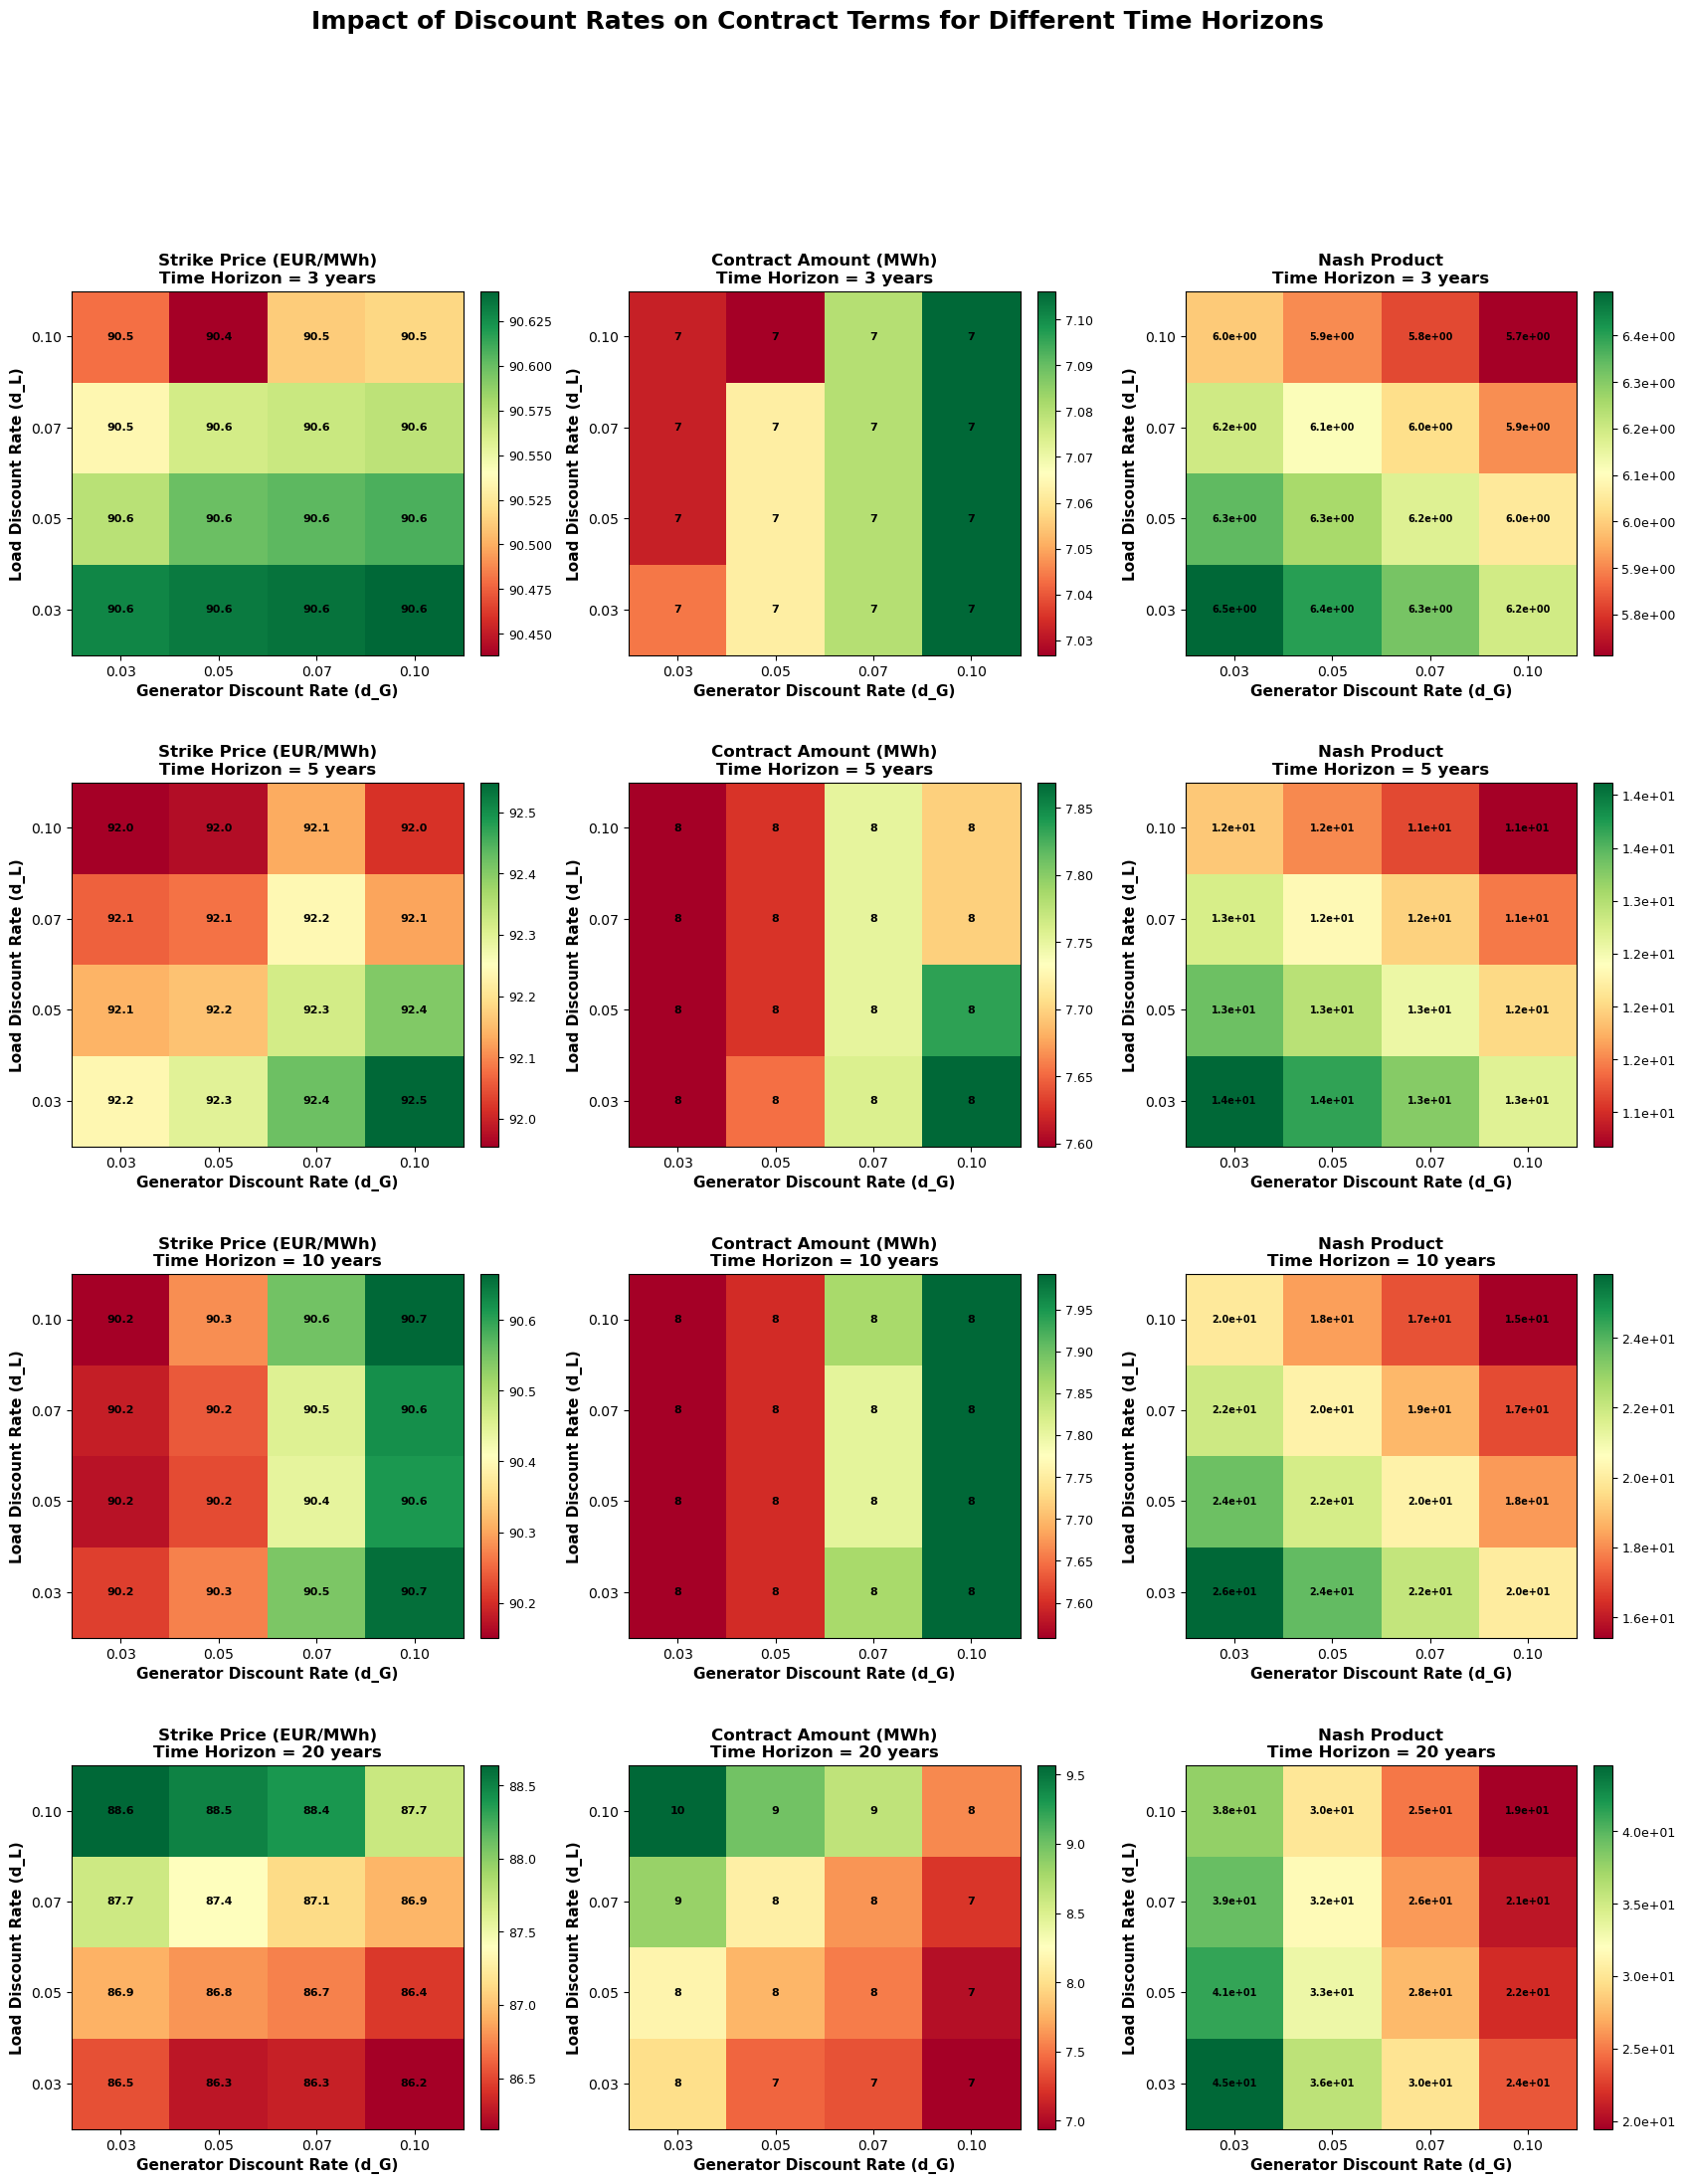

In [20]:
# Visualization 3: Heatmaps for Each Time Horizon
# Show how S, M, and Nash Product vary with (d_G, d_L) for each time horizon

# Create figure with 4 rows (one per time horizon) × 3 columns (S, M, Nash)
fig = plt.figure(figsize=(20, 24))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

for row_idx, T in enumerate(time_horizons):
    df_T = df_time_sensitivity[df_time_sensitivity['time_horizon'] == T].copy()
    
    # Create pivot tables for this time horizon
    pivot_S_T = df_T.pivot(index='d_L', columns='d_G', values='S_optimal')
    pivot_M_T = df_T.pivot(index='d_L', columns='d_G', values='M_optimal_MWh')
    pivot_Nash_T = df_T.pivot(index='d_L', columns='d_G', values='Nash_Product')
    
    # Column 1: Strike Price
    ax1 = fig.add_subplot(gs[row_idx, 0])
    im1 = ax1.imshow(pivot_S_T, cmap='RdYlGn', aspect='auto', origin='lower')
    ax1.set_xticks(np.arange(len(discount_rates_time)))
    ax1.set_yticks(np.arange(len(discount_rates_time)))
    ax1.set_xticklabels([f'{d:.2f}' for d in discount_rates_time], fontsize=10)
    ax1.set_yticklabels([f'{d:.2f}' for d in discount_rates_time], fontsize=10)
    ax1.set_xlabel('Generator Discount Rate (d_G)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Load Discount Rate (d_L)', fontsize=11, fontweight='bold')
    ax1.set_title(f'Strike Price (EUR/MWh)\nTime Horizon = {T} years', fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.ax.tick_params(labelsize=9)
    
    # Add text annotations
    for i in range(len(discount_rates_time)):
        for j in range(len(discount_rates_time)):
            val = pivot_S_T.iloc[i, j]
            if not np.isnan(val):
                text = ax1.text(j, i, f'{val:.1f}', ha='center', va='center', 
                               color='black', fontsize=8, fontweight='bold')
    
    # Column 2: Contract Amount
    ax2 = fig.add_subplot(gs[row_idx, 1])
    im2 = ax2.imshow(pivot_M_T, cmap='RdYlGn', aspect='auto', origin='lower')
    ax2.set_xticks(np.arange(len(discount_rates_time)))
    ax2.set_yticks(np.arange(len(discount_rates_time)))
    ax2.set_xticklabels([f'{d:.2f}' for d in discount_rates_time], fontsize=10)
    ax2.set_yticklabels([f'{d:.2f}' for d in discount_rates_time], fontsize=10)
    ax2.set_xlabel('Generator Discount Rate (d_G)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Load Discount Rate (d_L)', fontsize=11, fontweight='bold')
    ax2.set_title(f'Contract Amount (MWh)\nTime Horizon = {T} years', fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.ax.tick_params(labelsize=9)
    
    # Add text annotations
    for i in range(len(discount_rates_time)):
        for j in range(len(discount_rates_time)):
            val = pivot_M_T.iloc[i, j]
            if not np.isnan(val):
                text = ax2.text(j, i, f'{val:.0f}', ha='center', va='center', 
                               color='black', fontsize=8, fontweight='bold')
    
    # Column 3: Nash Product
    ax3 = fig.add_subplot(gs[row_idx, 2])
    im3 = ax3.imshow(pivot_Nash_T, cmap='RdYlGn', aspect='auto', origin='lower')
    ax3.set_xticks(np.arange(len(discount_rates_time)))
    ax3.set_yticks(np.arange(len(discount_rates_time)))
    ax3.set_xticklabels([f'{d:.2f}' for d in discount_rates_time], fontsize=10)
    ax3.set_yticklabels([f'{d:.2f}' for d in discount_rates_time], fontsize=10)
    ax3.set_xlabel('Generator Discount Rate (d_G)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Load Discount Rate (d_L)', fontsize=11, fontweight='bold')
    ax3.set_title(f'Nash Product\nTime Horizon = {T} years', fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04, format='%.1e')
    cbar3.ax.tick_params(labelsize=9)
    
    # Add text annotations (scientific notation)
    for i in range(len(discount_rates_time)):
        for j in range(len(discount_rates_time)):
            val = pivot_Nash_T.iloc[i, j]
            if not np.isnan(val):
                text = ax3.text(j, i, f'{val:.1e}', ha='center', va='center', 
                               color='black', fontsize=7, fontweight='bold')

plt.suptitle('Impact of Discount Rates on Contract Terms for Different Time Horizons', 
             fontsize=18, fontweight='bold', y=0.998)

plt.tight_layout()
plt.show()

C:\Users\ande7\AppData\Local\Temp\ipykernel_8692\2673526066.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


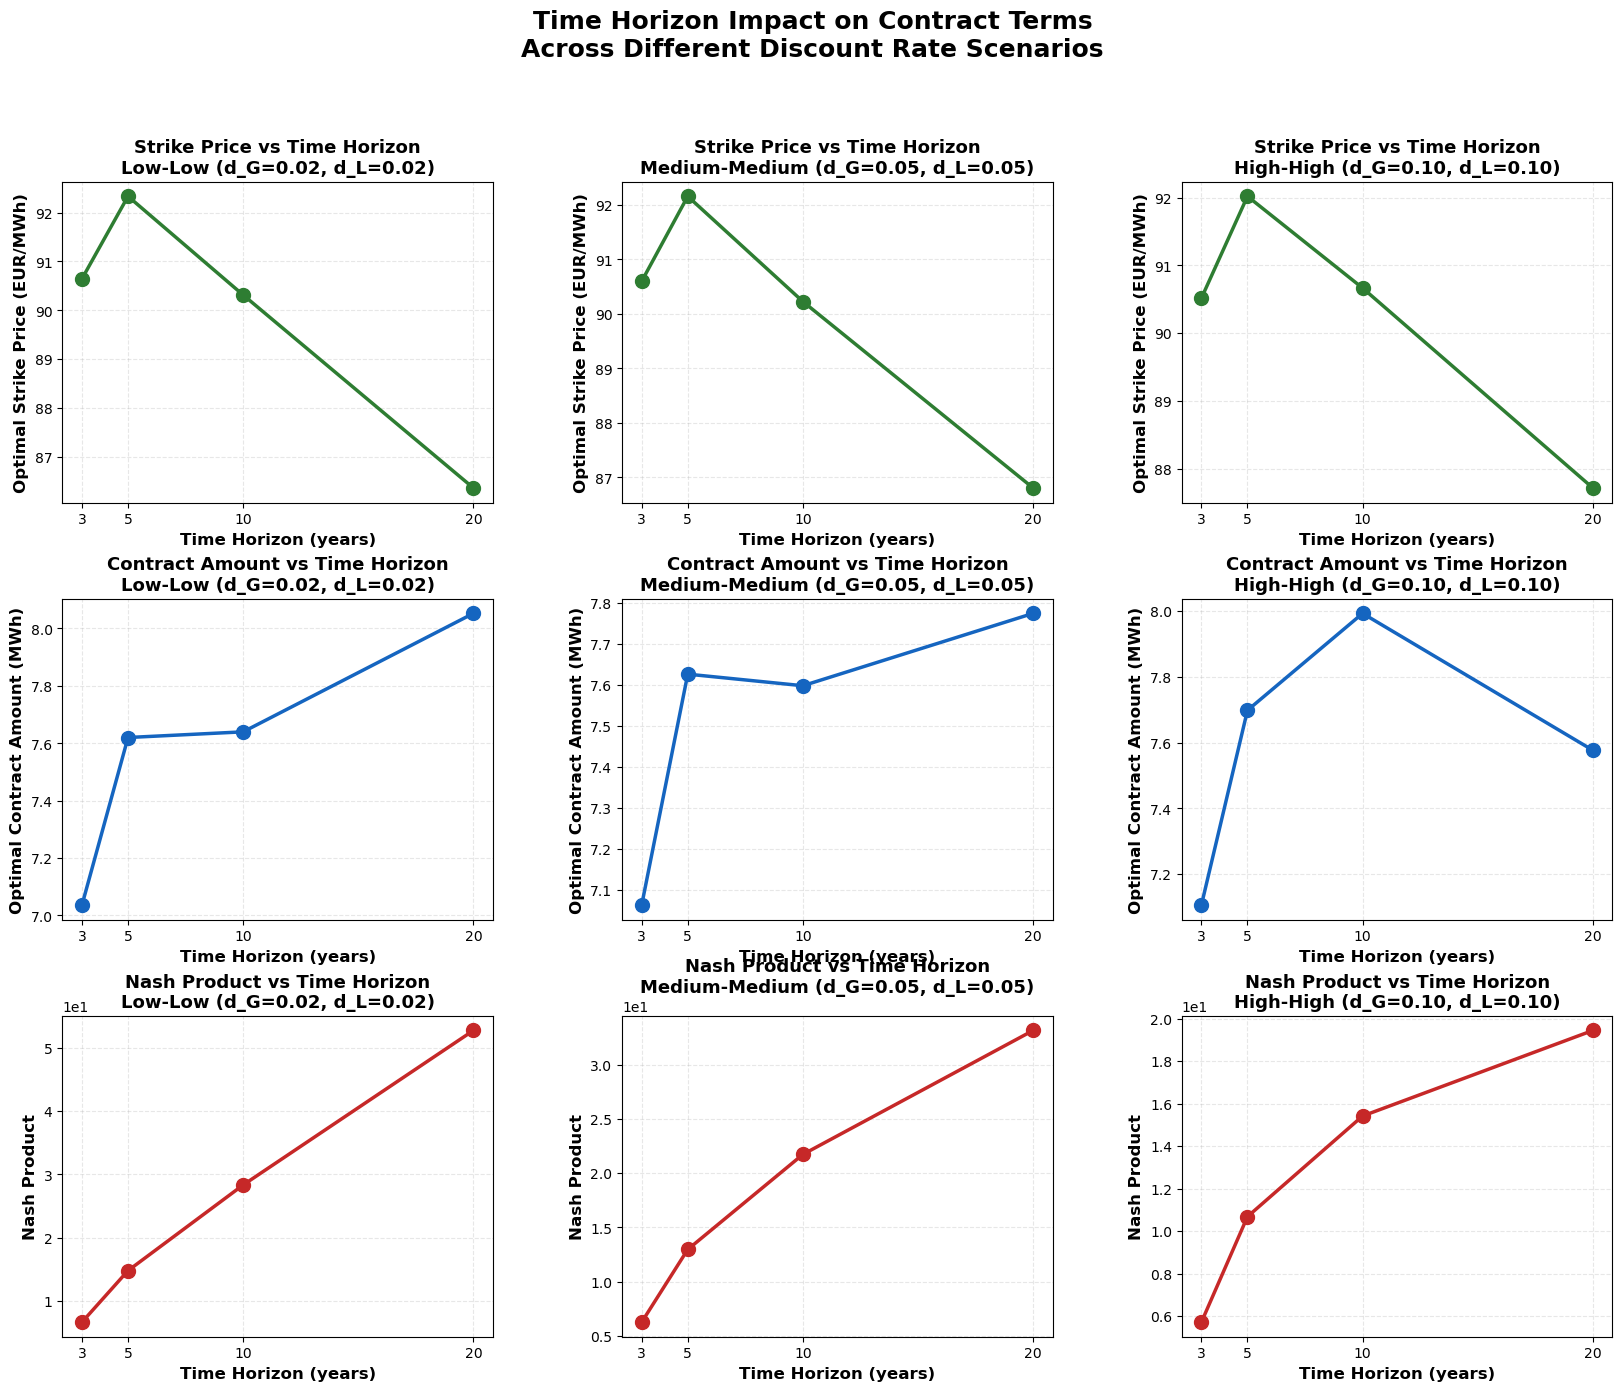

In [12]:
# Visualization 1: Line Plots Showing Impact of Time Horizon
# For each discount rate combination, show how S, M, and Nash Product vary with time horizon

# Create figure with 3 rows × 3 columns (one row per metric, one column per discount rate combo)
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Define discount rate combinations to plot
discount_combos = [
    (0.02, 0.02, 'Low-Low (d_G=0.02, d_L=0.02)'),
    (0.05, 0.05, 'Medium-Medium (d_G=0.05, d_L=0.05)'),
    (0.10, 0.10, 'High-High (d_G=0.10, d_L=0.10)')
]

# Row 1: Strike Price
for col_idx, (dG, dL, label) in enumerate(discount_combos):
    ax = fig.add_subplot(gs[0, col_idx])
    df_combo = df_time_sensitivity[(df_time_sensitivity['d_G'] == dG) & (df_time_sensitivity['d_L'] == dL)]
    
    if len(df_combo) > 0:
        ax.plot(df_combo['time_horizon'], df_combo['S_optimal'], 'o-', linewidth=2.5, markersize=10, color='#2E7D32')
        ax.set_xlabel('Time Horizon (years)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Optimal Strike Price (EUR/MWh)', fontsize=12, fontweight='bold')
        ax.set_title(f'Strike Price vs Time Horizon\n{label}', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xticks(time_horizons)
    else:
        ax.text(0.5, 0.5, 'No feasible solutions', ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{label}\nNo feasible solutions', fontsize=11, fontweight='bold')

# Row 2: Contract Amount
for col_idx, (dG, dL, label) in enumerate(discount_combos):
    ax = fig.add_subplot(gs[1, col_idx])
    df_combo = df_time_sensitivity[(df_time_sensitivity['d_G'] == dG) & (df_time_sensitivity['d_L'] == dL)]
    
    if len(df_combo) > 0:
        ax.plot(df_combo['time_horizon'], df_combo['M_optimal_MWh'], 'o-', linewidth=2.5, markersize=10, color='#1565C0')
        ax.set_xlabel('Time Horizon (years)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Optimal Contract Amount (MWh)', fontsize=12, fontweight='bold')
        ax.set_title(f'Contract Amount vs Time Horizon\n{label}', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xticks(time_horizons)
    else:
        ax.text(0.5, 0.5, 'No feasible solutions', ha='center', va='center', transform=ax.transAxes, fontsize=12)

# Row 3: Nash Product
for col_idx, (dG, dL, label) in enumerate(discount_combos):
    ax = fig.add_subplot(gs[2, col_idx])
    df_combo = df_time_sensitivity[(df_time_sensitivity['d_G'] == dG) & (df_time_sensitivity['d_L'] == dL)]
    
    if len(df_combo) > 0:
        ax.plot(df_combo['time_horizon'], df_combo['Nash_Product'], 'o-', linewidth=2.5, markersize=10, color='#C62828')
        ax.set_xlabel('Time Horizon (years)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Nash Product', fontsize=12, fontweight='bold')
        ax.set_title(f'Nash Product vs Time Horizon\n{label}', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xticks(time_horizons)
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    else:
        ax.text(0.5, 0.5, 'No feasible solutions', ha='center', va='center', transform=ax.transAxes, fontsize=12)

plt.suptitle('Time Horizon Impact on Contract Terms\nAcross Different Discount Rate Scenarios', 
             fontsize=18, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()